This notebook tries to reproduce the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

We also study the effect the norm of the data has on learning.
We generate spheres of radius $O(1)$ and $O(\sqrt{D})$.
The radius $O(\sqrt{D})$ setting is meant to model how image inputs are fed into NNs in practice.

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

### Data generation utils

In [2]:
def normalize_vectors(xs):
    return xs / np.linalg.norm(xs, ord=2, axis=1, keepdims=True)

def sample_unit_sphere(num_samples, dim):
    return normalize_vectors(
        np.random.normal(size=(num_samples, dim))
    )

def generate_sphere_data(dim, r1, r2, num_samples):
    assert num_samples % 2 == 0
    
    xs = np.concatenate([
        r1 * sample_unit_sphere(num_samples // 2, dim),
        r2 * sample_unit_sphere(num_samples // 2, dim)
    ])
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

generate_sphere_data(dim=2, r1=1, r2=10, num_samples=4)

(array([[ 0.18248647,  0.98320836],
        [ 6.21542038, -7.83380811],
        [ 8.34962306, -5.5030714 ],
        [-0.99948767, -0.03200622]]),
 array([0, 1, 1, 0]))

### Experiment setup

In [3]:
def run_experiment(
    dim,
    r1, r2,
    model_layers,
    train_batch_size,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    attack_batch_size=1024,
    num_train=5 * 10 ** 4,
    num_test=10 ** 4,
    seed=42
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_sphere_data(
        dim=dim, r1=r1, r2=r2,
        num_samples=num_train,
    )

    x_test, y_test = generate_sphere_data(
        dim=dim, r1=r1, r2=r2,
        num_samples=num_test,
    )
    
    model = keras.Sequential(
        [keras.Input(shape=x_train[0].shape)]
        + model_layers
    )
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        x_train,
        y_train,
        batch_size=train_batch_size,
        epochs=train_epochs,
        validation_data=(x_test, y_test),
        verbose=2,
    )
    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        clip_values=[-x_test.max(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_train_adv = art_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv = art_attack.generate(x_test, y=y_test)
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_train_acc = model.evaluate(x_train_adv, y_train[:num_test], verbose=0)
    _, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)
    
    print("Nat train acc :", nat_train_acc)
    print("Nat test  acc :", nat_test_acc)
    print("Adv train acc :", adv_train_acc)
    print("Adv test  acc :", adv_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv=x_train_adv,
        x_test_adv=x_test_adv,
    )

### Run experiments

Norm $O(1)$

In [4]:
%%time
D = 500
res = run_experiment(
    dim=D,
    r1=1.0, r2=1.3,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=5,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/5
391/391 - 3s - loss: 0.1228 - accuracy: 0.9469 - val_loss: 0.0166 - val_accuracy: 0.9947
Epoch 2/5
391/391 - 3s - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0042 - val_accuracy: 0.9992
Epoch 3/5
391/391 - 3s - loss: 3.4914e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9998
Epoch 4/5
391/391 - 3s - loss: 6.0789e-05 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 0.9998
Epoch 5/5
391/391 - 3s - loss: 3.5033e-05 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 0.9998


PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 1.0
Nat test  acc : 0.9998000264167786
Adv train acc : 0.5234000086784363
Adv test  acc : 0.3785000145435333
CPU times: user 6min 31s, sys: 47.5 s, total: 7min 18s
Wall time: 32.7 s


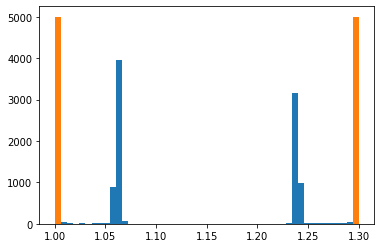

In [5]:
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50);
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50);

---

Norm $O(\sqrt{D})$

In [6]:
%%time
D = 500
res = run_experiment(
    dim=D,
    r1=1.0 * np.sqrt(D), r2=1.3 * np.sqrt(D),
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=30,
    attack_norm=2,
    attack_eps=0.1 * np.sqrt(D),
    attack_eps_step=0.01 * np.sqrt(D),
    attack_iters=20,
)

Epoch 1/30
391/391 - 3s - loss: 0.6797 - accuracy: 0.5562 - val_loss: 0.6558 - val_accuracy: 0.5338
Epoch 2/30
391/391 - 3s - loss: 0.4618 - accuracy: 0.7783 - val_loss: 0.3994 - val_accuracy: 0.8116
Epoch 3/30
391/391 - 3s - loss: 0.1407 - accuracy: 0.9470 - val_loss: 0.3054 - val_accuracy: 0.8741
Epoch 4/30
391/391 - 3s - loss: 0.0703 - accuracy: 0.9741 - val_loss: 0.2788 - val_accuracy: 0.8922
Epoch 5/30
391/391 - 3s - loss: 0.0408 - accuracy: 0.9859 - val_loss: 0.2879 - val_accuracy: 0.8896
Epoch 6/30
391/391 - 3s - loss: 0.0386 - accuracy: 0.9859 - val_loss: 0.2312 - val_accuracy: 0.9125
Epoch 7/30
391/391 - 3s - loss: 0.0318 - accuracy: 0.9884 - val_loss: 0.2351 - val_accuracy: 0.9196
Epoch 8/30
391/391 - 3s - loss: 0.0281 - accuracy: 0.9896 - val_loss: 0.2246 - val_accuracy: 0.9205
Epoch 9/30
391/391 - 3s - loss: 0.0277 - accuracy: 0.9901 - val_loss: 0.2306 - val_accuracy: 0.9208
Epoch 10/30
391/391 - 3s - loss: 0.0248 - accuracy: 0.9912 - val_loss: 0.2782 - val_accuracy: 0.9150

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9987999796867371
Nat test  acc : 0.9696000218391418
Adv train acc : 0.5264000296592712
Adv test  acc : 0.28679999709129333
CPU times: user 23min 3s, sys: 2min 32s, total: 25min 35s
Wall time: 1min 46s


---

Norm $O(1)$ + BatchNorm

In [7]:
%%time
D = 500
res = run_experiment(
    dim=D,
    r1=1.0, r2=1.3,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=5,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/5
391/391 - 4s - loss: 0.0304 - accuracy: 0.9886 - val_loss: 0.2996 - val_accuracy: 0.8464
Epoch 2/5
391/391 - 4s - loss: 0.0159 - accuracy: 0.9945 - val_loss: 0.0129 - val_accuracy: 0.9962
Epoch 3/5
391/391 - 4s - loss: 0.0126 - accuracy: 0.9956 - val_loss: 0.0181 - val_accuracy: 0.9942
Epoch 4/5
391/391 - 4s - loss: 0.0107 - accuracy: 0.9963 - val_loss: 0.0240 - val_accuracy: 0.9932
Epoch 5/5
391/391 - 4s - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0198 - val_accuracy: 0.9932


PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9968799948692322
Nat test  acc : 0.9932000041007996
Adv train acc : 0.5048999786376953
Adv test  acc : 0.4657000005245209
CPU times: user 7min 10s, sys: 55.5 s, total: 8min 6s
Wall time: 38.8 s


---

Norm $O(\sqrt{D})$ + BatchNorm

In [8]:
%%time
D = 500
res = run_experiment(
    dim=D,
    r1=1.0 * np.sqrt(D), r2=1.3 * np.sqrt(D),
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1 * np.sqrt(D),
    attack_eps_step=0.01 * np.sqrt(D),
    attack_iters=20,
)

Epoch 1/10
391/391 - 4s - loss: 0.0707 - accuracy: 0.9758 - val_loss: 0.0953 - val_accuracy: 0.9673
Epoch 2/10
391/391 - 4s - loss: 0.0336 - accuracy: 0.9880 - val_loss: 0.0484 - val_accuracy: 0.9840
Epoch 3/10
391/391 - 4s - loss: 0.0263 - accuracy: 0.9907 - val_loss: 0.0215 - val_accuracy: 0.9921
Epoch 4/10
391/391 - 4s - loss: 0.0292 - accuracy: 0.9901 - val_loss: 0.0229 - val_accuracy: 0.9916
Epoch 5/10
391/391 - 4s - loss: 0.0260 - accuracy: 0.9910 - val_loss: 0.0337 - val_accuracy: 0.9884
Epoch 6/10
391/391 - 4s - loss: 0.0233 - accuracy: 0.9921 - val_loss: 0.0257 - val_accuracy: 0.9914
Epoch 7/10
391/391 - 4s - loss: 0.0218 - accuracy: 0.9922 - val_loss: 0.0199 - val_accuracy: 0.9932
Epoch 8/10
391/391 - 4s - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0265 - val_accuracy: 0.9914
Epoch 9/10
391/391 - 4s - loss: 0.0205 - accuracy: 0.9931 - val_loss: 0.0424 - val_accuracy: 0.9875
Epoch 10/10
391/391 - 4s - loss: 0.0166 - accuracy: 0.9947 - val_loss: 0.0208 - val_accuracy: 0.9925

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9978600144386292
Nat test  acc : 0.9925000071525574
Adv train acc : 0.6022999882698059
Adv test  acc : 0.5054000020027161
CPU times: user 10min 46s, sys: 1min 24s, total: 12min 10s
Wall time: 57.7 s


### Summary and conclusions

Our perturbation epsilon is chosen such that the max-margin classifier should have perfect robust accuracy.
However we see that our neural networks are far from robust.

Interestingly, it seems our neural networks train much quicker
when the data is of norm $O(1)$ compared to norm $O(\sqrt{D})$.
This difference can be mitigated with batchnorm.

It is also interesting to note that batchnorm seems to improve robustness.